In [202]:
'''
First import modules used.  If you have any trouble with the modules, they may not be installed.  Just delete the '#'
in front of the module you'd like to use and run this cell again.
'''

#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install csv
#!pip install sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error

%matplotlib inline

In [218]:
'''
We extract the measured intensity fluctuations from our source.
'''


df_intensity_arr = []

# We clean the data and extract intensity using a for loop.  There are 5 data files, each with a 10 minute
# measurement time.

for i in range(1,5):
    string = 'PowerSample_' + str(i) + '.csv'
    cols = ['itr','date','Power']

    df = pd.read_csv(string, sep='delimiter', names = cols,engine='python')
    df = df[15:76]

    lines = []
    for line in df['itr']:
        line = line.split(',')
        lines.append(line)

    df = pd.DataFrame(lines)
    intensity_array = df[3]
    df_intensity = intensity_array.values.tolist()
    df_intensity_arr.append(df_intensity)

    for i in range(0, len(df_intensity)):
        df_intensity[i] = float(df_intensity[i])
        
df_intensity_arr = np.concatenate(df_intensity_arr, axis=0)

In [204]:
'''
We construct an array 'arr' which holds the time in seconds over the course of intensity measurements.
'''

arr = []
j=0
for i in range(237):
    arr.append(j)
    j = j + 10

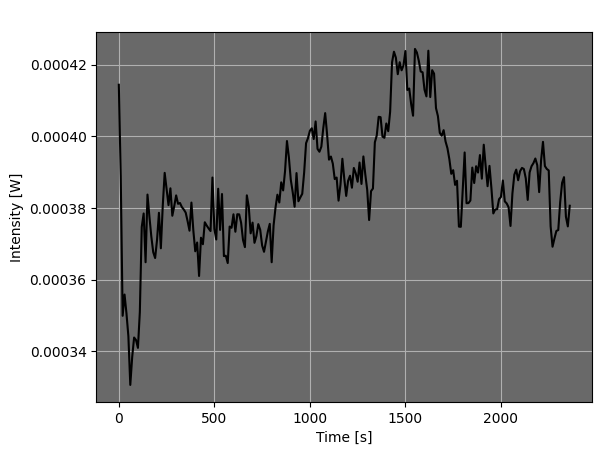

In [205]:
'''
We graph intensity vs. time (10 second incremented measurements) of our power source.
'''

plt.plot(arr,df_intensity_arr,color= 'black')
plt.title('Intensity vs. Time')
plt.xlabel('Time [s]')
plt.ylabel('Intensity [W]')
plt.grid()
plt.show()

In [206]:
randomList=[]
for i in range(1000):
   r=random.randint(0,121)
   if r not in randomList and r%2 == 0:
      randomList.append(r)

'''
Our polarizer gave an extinction angle of 52 degrees.  We counted this as 0 degrees and intended on phase shifting our angles.
So we subtracted all of our angles by 38.
'''

df_random = pd.DataFrame(randomList,columns = ['Angle'])
df_random['Shifted_Angle'] = df_random['Angle']-38
df_random

,Angle,Shifted_Angle
0,54,16
1,14,-24
2,76,38
3,4,-34
4,16,-22
...,...,...
56,0,-38
57,110,72
58,72,34
59,56,18


In [215]:
'''
While making measurements, we turned the polarizer angle to the next random number generated in the previous cell, until
all data points were taken.  We then saved each into a .csv file format.  The files were under naming convention:

n20.csv,n18.csv...0.csv,2.csv...100.csv

We cleaned the data, took averages of each file and arranged them all in an array.  We also made an array of the angles.
'''


avrg = []
angle = []

for i in reversed(range(2,21,2)):
    string = 'n' + str(i) + '.csv'
    df = pd.read_csv(string, sep='delimiter',engine='python')
    df = df[12:14]
    df.columns=['itr']
    lines = []
    for line in df['itr']:
        line = line.split(',')
        lines.append(line)
    df = pd.DataFrame(lines)
    intensity = df[3]  
    intensity = intensity.values.tolist()
    for j in range(0, len(intensity)):
        intensity[j] = float(intensity[j])
    avg = np.mean(intensity)
    avrg.append(avg)
    angle.append(-i)

for i in range(0,101,2):
    string = str(i) + '.csv'
    df = pd.read_csv(string, sep='delimiter',engine='python')
    df = df[12:14]
    df.columns=['itr']
    lines = []
    for line in df['itr']:
        line = line.split(',')
        lines.append(line)
    df = pd.DataFrame(lines)
    intensity = df[3]
    intensity = intensity.values.tolist()
    for j in range(0, len(intensity)):
        intensity[j] = float(intensity[j])
    avg = np.mean(intensity)
    avrg.append(avg)
    angle.append(i)

In [216]:
%%capture
'''
Finds fit with highest r2_score.  We don't use this fit, but it is useful because it provides the scaling factor we
need in order to to fit the cos^2 function later.
'''

r2_search = []
for i in range(1,100):

    model = np.poly1d(np.polyfit(angle,avrg,i))
    line = np.linspace(-20,100,60)
    r2 = r2_score(avrg,model(angle))
    r2_search.append(r2)
    
max_r2 = r2_search.index(max(r2_search))

In [209]:
'''
Creates the cos^2 function we are trying to fit.  We use our 'best r_2' model to scale the amplitude.
'''

values = []
for angles in range(len(angle)):
    value = max(model(line))*np.cos(np.deg2rad(angle[angles]))**2
    values.append(value)

In [217]:
%%capture
'''
The fit we used before was only to maximize the r2 score to match our data.  This was only intended to be used to generate
the scaling factor for our cos^2 curve.

We now create a new model that minimizes variance between the regression and the cos^2 function.
'''

variance = []
for i in range(1,150):

    model = np.poly1d(np.polyfit(angle,avrg,i))
    line = np.linspace(-20,100,60)
    dist = np.mean(np.abs(model-values))
    variance.append(dist)
    
best_fit = variance.index(min(variance))

model = np.poly1d(np.polyfit(angle,avrg,best_fit))
line = np.linspace(-20,100,60)

In [211]:
'''
Since the cos^2 function is continuous, we break it down to match the shape of our angle vector.
'''

cos_values = []

for angles in angle:
    cos_value = max(model(line))*np.cos(np.deg2rad(angles))**2
    cos_values.append(cos_value)

In [212]:
'''
A few of our vectors carry an extra data point, so we pop it out.
'''

cos_pop = cos_values.copy()
cos_pop.pop()
angle_pop = angle.copy()
angle_pop.pop()
avrg_pop = avrg.copy()
avrg_pop.pop()
values_pop = values.copy()
values_pop.pop()

'''
Doing this, we are able to calculate mean squared error between our regression curve and our cos^2 function
'''

mse = mean_squared_error(cos_pop,model(line))

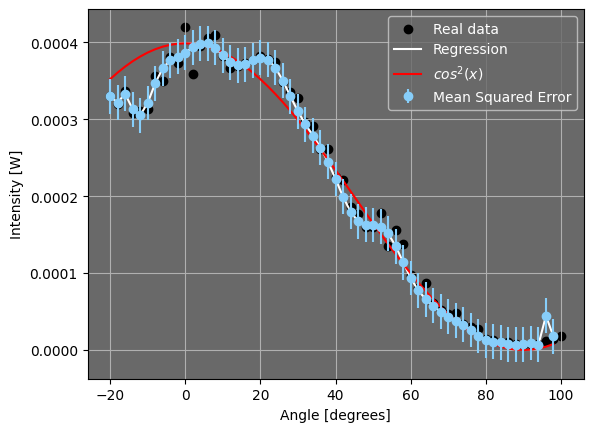

In [214]:
'''
Lastly, we are able to fit our 'best fit' regression curve to the data with error bars based on the mean squared error.
'''
plt.scatter(angle,avrg,color = 'black',label = 'Real data')
plt.plot(angle_pop,model(line),color='white',label = 'Regression')
plt.plot(angle_pop,values_pop,color = 'r',label = '$cos^{2}(x)$')
plt.xlabel('Angle [degrees]')
plt.ylabel('Intensity [W]')
plt.grid()
plt.errorbar(angle_pop,model(line),np.sqrt(mse),color='lightskyblue',label='Mean Squared Error',fmt='o')
plt.legend()
plt.rcParams['axes.facecolor'] = 'dimgrey'
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "black"})
plt.show()